In [32]:
import os

if os.system('nvidia-smi'):
  raise Exception("Gpu unavailable")

In [33]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [34]:
# GPU check
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.2 GB  | Proc size: 771.6 MB
GPU RAM Free: 15101MB | Used: 0MB | Util   0% | Total 15360MB


In [35]:
# Loading the Fashion-MNIST dataset
from torchvision import datasets, transforms

In [36]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

In [37]:
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)


In [38]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


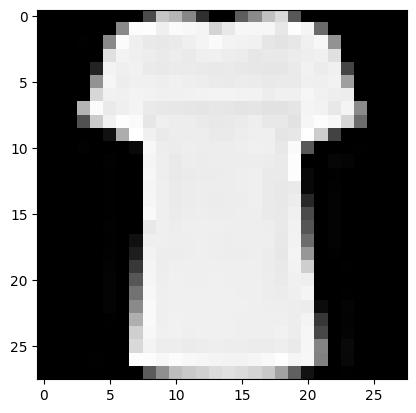

In [39]:
plt.imshow(images[1].numpy().squeeze(), cmap = 'Greys_r')

In [40]:
labels[1].item()

6

In [41]:
text_labels=['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
             'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']


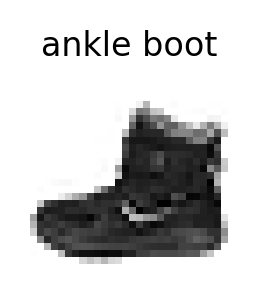

In [44]:
import matplotlib.pyplot as plt
plt.figure(dpi=300,figsize=(8,4))
for i in range(1):
    ax=plt.subplot(3, 8, i + 1)    #A
    img=trainset[i][0]    #B
    img=img/2+0.5    #C
    img=img.reshape(28, 28)    #D
    plt.imshow(img,
               cmap="binary")
    plt.axis('off')
    plt.title(text_labels[trainset[i][1]],    #E
        fontsize=8)
plt.show()


In [45]:
# Define the network architecture
from torch import nn, optim
import torch.nn.functional as F

model = nn.Sequential(nn.Linear(784, 256),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim = 1)
                     )

In [46]:
# Define the loss
criterion = nn.NLLLoss()

In [47]:
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.002)

In [48]:
# Define the epochs
epochs = 30

train_losses, test_losses = [], []

In [49]:
for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    # Flatten Fashion-MNIST images into a 784 long vector
    images = images.view(images.shape[0], -1)

    # Training pass
    optimizer.zero_grad()

    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0

    # Turn off gradients for validation, saves memory and computation
    with torch.no_grad():
      # Set the model to evaluation mode
      model.eval()

      # Validation pass
      for images, labels in testloader:
        images = images.view(images.shape[0], -1)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))

    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))

    print("Epoch: {}/{}..".format(e+1, epochs),
          "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))


Epoch: 1/30.. Training loss: 0.586.. Test loss: 0.454.. Test Accuracy: 0.834
Epoch: 2/30.. Training loss: 0.456.. Test loss: 0.422.. Test Accuracy: 0.849
Epoch: 3/30.. Training loss: 0.421.. Test loss: 0.407.. Test Accuracy: 0.853
Epoch: 4/30.. Training loss: 0.400.. Test loss: 0.408.. Test Accuracy: 0.852
Epoch: 5/30.. Training loss: 0.383.. Test loss: 0.403.. Test Accuracy: 0.857
Epoch: 6/30.. Training loss: 0.376.. Test loss: 0.402.. Test Accuracy: 0.854
Epoch: 7/30.. Training loss: 0.368.. Test loss: 0.360.. Test Accuracy: 0.870
Epoch: 8/30.. Training loss: 0.358.. Test loss: 0.376.. Test Accuracy: 0.867
Epoch: 9/30.. Training loss: 0.351.. Test loss: 0.364.. Test Accuracy: 0.870
Epoch: 10/30.. Training loss: 0.347.. Test loss: 0.370.. Test Accuracy: 0.868
Epoch: 11/30.. Training loss: 0.339.. Test loss: 0.357.. Test Accuracy: 0.875
Epoch: 12/30.. Training loss: 0.338.. Test loss: 0.356.. Test Accuracy: 0.875
Epoch: 13/30.. Training loss: 0.331.. Test loss: 0.363.. Test Accuracy: 0

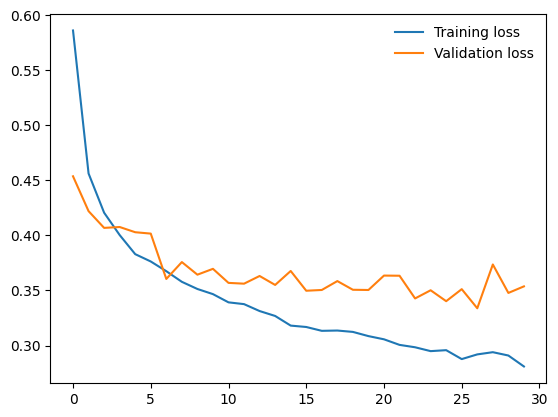

In [50]:
plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "Validation loss")
plt.legend(frameon = False)